In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import random
import scipy.stats as stats

In [51]:
# load data: https://www.kaggle.com/datasets/tejashvi14/medical-insurance-premium-prediction?select=Medicalpremium.csv
# data set to predict insurance premium based on demographic/health/other factors.
data = pd.read_csv("../AB/Medicalpremium.csv")
print(data.shape)
data.head()

(986, 11)


,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


In [52]:
from sklearn.preprocessing import StandardScaler
colnames = list(data)
X = data[colnames[:-1]]
Xsc = StandardScaler().fit_transform(X)
y = data[colnames[-1]]
Xsc

array([[ 0.23319694, -0.85075039, -0.93897784, ..., -0.52335629,
        -0.36514837, -0.89118667],
       [ 1.30798124,  1.1754329 , -0.93897784, ..., -0.52335629,
        -0.36514837, -0.89118667],
       [-0.41167363,  1.1754329 ,  1.06498786, ..., -0.52335629,
        -0.36514837,  0.44423895],
       ...,
       [ 1.02137209, -0.85075039,  1.06498786, ..., -0.52335629,
        -0.36514837,  0.44423895],
       [ 0.37650152,  1.1754329 ,  1.06498786, ...,  1.9107442 ,
        -0.36514837,  0.44423895],
       [-1.48645793, -0.85075039, -0.93897784, ...,  1.9107442 ,
        -0.36514837,  0.44423895]])

In [57]:
test_percentage = 0.2
X_train, X_test, y_train, y_test = train_test_split(Xsc, y, test_size=test_percentage, random_state=1)

params=[{'n_estimators': [56], 'max_depth': [5], 'min_child_weight':[1]}]
xgb1 = XGBRegressor(learning_rate =0.1, subsample=0.8, 
                    colsample_bytree=0.8, scale_pos_weight=1, seed=10)
gs1 = GridSearchCV(xgb1, param_grid = params, scoring='neg_mean_squared_error',cv = 10)
gs1.fit(X_train,y_train)
gs1.best_params_

{'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 56}

In [65]:
# compare two sample, cuped with prediction (theta is on prediction), prediction, and 
# cuped with residual (theta is on covariate, regressing on outcome - prediction)
np.random.seed(1)
random.seed(1)
y = y_test.reset_index(drop=True)
x = X_test
n = len(y)
te = 3000
sim_num = 1000
temp = []
n0 = n
n1 = n
pred_var = 0
preds = gs1.predict(X_test)
for i in range(sim_num):
    #control_idx = random.sample(range(n),n//2)
    #treat_idx = list(set(range(n)).difference(control_idx))
    # or if with replacement
    control_idx = random.choices(range(n), k=n0)
    treat_idx = random.choices(range(n), k=n1)
    control_idx.sort()
    treat_idx.sort()
    control_x = x[control_idx]
    treat_x = x[treat_idx]
    control_y = y[control_idx]
    treat_y = y[treat_idx] + te
    #preds = pre_exp(x) + np.random.normal(0,pred_var**0.5,n)
    r_treat = treat_y - preds[treat_idx]
    r_control = control_y - preds[control_idx]
    
    # cuped with residual
    # need to use CENTERED X and CENTERED R in optimal beta (or it will give biased result)
    r_treat_bar = r_treat - r_treat.mean()
    r_control_bar = r_control - r_control.mean()
    treat_x_bar = treat_x - treat_x.mean(axis=0)
    control_x_bar = control_x - control_x.mean(axis=0)
    optimal_beta = np.matmul(np.linalg.inv(np.matmul(np.transpose(treat_x_bar),treat_x_bar)/n1 + np.matmul(np.transpose(control_x_bar),control_x_bar)/n0),
                    (np.matmul(np.transpose(treat_x_bar), r_treat_bar)/n1 + np.matmul(np.transpose(control_x_bar), r_control_bar)/n0))
    optimal_alpha1 = np.mean(r_treat) - np.mean(np.matmul(treat_x,optimal_beta))
    optimal_alpha0 = np.mean(r_control) - np.mean(np.matmul(control_x,optimal_beta))
    cf_for_treat = preds[treat_idx] + optimal_alpha0 + np.mean(np.matmul(treat_x,optimal_beta))
    cf_for_control = preds[control_idx] + optimal_alpha1 + np.mean(np.matmul(control_x,optimal_beta))
    #pair_est = optimal_alpha1 - optimal_alpha0
    pair_est = (np.sum(treat_y - cf_for_treat) + np.sum(cf_for_control - control_y))/(n1+n0)
    pair_se = (np.var(r_treat-optimal_alpha1-np.matmul(treat_x_bar,optimal_beta))/n1 +\
               np.var(r_control-optimal_alpha0-np.matmul(control_x_bar,optimal_beta))/n0)**0.5
    
    # two sample t test
    two_est = np.mean(treat_y) - np.mean(control_y)
    two_se = (np.var(treat_y, ddof=1)/n1 + np.var(control_y, ddof=1)/n0)**0.5

    # prediction (constant shift)
    shift_alpha1 = np.mean(treat_y - preds[treat_idx])
    shift_alpha0 = np.mean(control_y - preds[control_idx])
    shift_for_treat = preds[treat_idx] + shift_alpha0
    shift_for_control = preds[control_idx] + shift_alpha1
    shift_pair_est = (np.sum(treat_y - shift_for_treat) + np.sum(shift_for_control - control_y))/(n1+n0)
    shift_se = (np.var(treat_y - preds[treat_idx],ddof=1)/n1 +\
                np.var(control_y - preds[control_idx],ddof=1)/n0)**0.5
    
    # cuped on prediction
    theta = (np.cov(preds[treat_idx], treat_y)[0,1]/n1 + np.cov(preds[control_idx], control_y)[0,1]/n0)/(np.var(preds[treat_idx])/n1 + np.var(preds[control_idx])/n0)
    cuped_est = np.mean(treat_y - theta * preds[treat_idx]) - np.mean(control_y - theta * preds[control_idx])
    cuped_se = (np.var(treat_y - theta * preds[treat_idx], ddof=1)/n1 + \
               np.var(control_y - theta * preds[control_idx], ddof=1)/n0)**0.5
    
    temp.append([pair_est, pair_se, two_est, two_se, shift_pair_est, shift_se, cuped_est, cuped_se])

sim_res = pd.DataFrame(temp, columns = ['pair_est', 'pair_se', 'two_est', 'two_se', 
                                        'shift_pair_est', 'shift_se', 'cuped_est', 'cuped_se'])

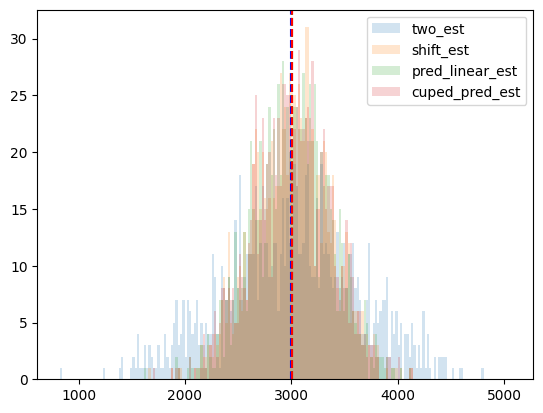

two_est           2999.717172
shift_pair_est    3005.197842
pair_est          3005.744508
cuped_est         3004.304696
dtype: float64
Bias: 
 two_est          -0.000094
shift_pair_est    0.001733
pair_est          0.001915
cuped_est         0.001435
dtype: float64


In [68]:
# set up bins
bin_min, bin_max = sim_res[['two_est','shift_pair_est','pair_est','cuped_est']].min().min(), sim_res[['two_est','shift_pair_est','pair_est','cuped_est']].max().max()
num_bins = 200
b_range = np.arange(bin_min, bin_max, (bin_max-bin_min)/num_bins)
plt.hist(sim_res['two_est'], bins = b_range, label = 'two_est', alpha=0.2)
plt.hist(sim_res['shift_pair_est'],bins = b_range,label='shift_est',alpha=0.2)
plt.hist(sim_res['pair_est'], bins = b_range,label='pred_linear_est',alpha=0.2)
plt.hist(sim_res['cuped_est'],bins = b_range, label='cuped_pred_est', alpha=0.2)
plt.axvline(np.mean(sim_res['two_est']), color = 'blue', linestyle='--')
plt.axvline(np.mean(sim_res['shift_pair_est']), color = 'orange', linestyle='--')
plt.axvline(np.mean(sim_res['pair_est']), color='green',linestyle='--')
plt.axvline(np.mean(sim_res['cuped_est']), color = 'red', linestyle='--')
plt.legend()
plt.show()
print("Bias%: \n", (sim_res[['two_est','shift_pair_est','pair_est','cuped_est']].mean()-te)/te)

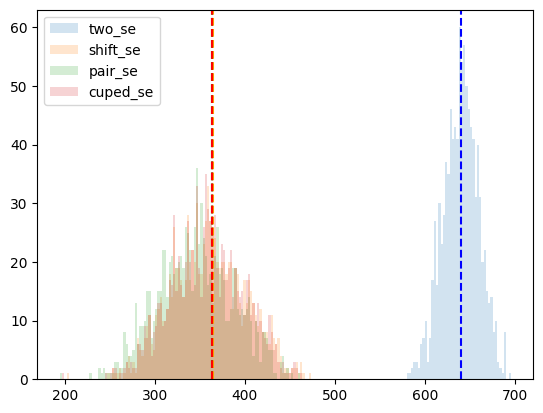

Variance Reduction%: 
 two_se      0.000000
shift_se    0.438610
pair_se     0.459536
cuped_se    0.440768
dtype: float64


In [70]:
bin_min, bin_max = sim_res[['two_se','shift_se','pair_se','cuped_se']].min().min(), sim_res[['two_se','shift_se','pair_se','cuped_se']].max().max()
num_bins = 200
b_range = np.arange(bin_min, bin_max, (bin_max-bin_min)/num_bins)
plt.hist(sim_res['two_se'], bins = b_range, label='two_se',alpha=0.2)
plt.hist(sim_res['shift_se'],bins = b_range,label='shift_se',alpha=0.2)
plt.hist(sim_res['pair_se'],bins = b_range,label='pair_se',alpha=0.2)
plt.hist(sim_res['cuped_se'],bins = b_range,label='cuped_se',alpha=0.2)
plt.axvline(np.std(sim_res['two_est'],ddof=1), color='blue', linestyle='--')
plt.axvline(np.std(sim_res['shift_pair_est'],ddof=1), color='orange', linestyle='--')
plt.axvline(np.std(sim_res['pair_est'],ddof=1), color='green', linestyle='--')
plt.axvline(np.std(sim_res['cuped_est'],ddof=1), color='red', linestyle='--')
plt.legend()
plt.show()
print("Variance Reduction%: \n", 1-(sim_res[['two_se','shift_se','pair_se','cuped_se']].mean()/sim_res['two_se'].mean()))